### Related works Architecture:

- Original Transformer

- BERT

- BART

- T5

- DeBERTa

- GPT-NeoX

- PaLM

In [1]:
from underthesea import word_tokenize
import re
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional
from transformers import AutoModel, AutoTokenizer

import sys, os
import difflib

# project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
# if project_root not in sys.path:
#     sys.path.append(project_root)

# from shared_functions.global_functions import *
# from shared_functions.gg_sheet import *

Just to keep in mind the wseg will not be used here to match with the PhoBERT tokenization algorithm

In [2]:
word_tokenize('Ban hành Nghị định sửa đổi Luật Đất đai')

['Ban hành', 'Nghị định', 'sửa đổi', 'Luật', 'Đất đai']

In [13]:
tokenizer.tokenize('Ban hành Nghị định sửa đổi Luật Đất đai')

['Ban', 'hành', 'Nghị', 'định', 'sửa', 'đổi', 'Luật', 'Đất', 'đai']

### Document type Mask matrix

To be used in the Self-attention layer of Encoder, note that although word_tokenize can be applied for Wseg, we have to follow the PhoBERT tokenization formula to maintain the consistency and thus making the mask 1 in both subwords of a Wseg

Having a tokenized sentence (by Wseg)

S = [$w_1, w_2,....w_N$]

and a lexicon (defined list of known legal document types)

Create a mask matrix $M_L \in R^{N x N}$

$m_ij$ = 1 if S[i:j] matches lexicon phrase

= 0 otherwise

Also rescale so that non-legal tokens can still attend to other tokens

In [3]:
def build_legal_mask(text):
    tokens = tokenizer.tokenize(text.lower())
    n = len(tokens)
    M = torch.zeros((n, n), dtype=torch.int)

    single = {'luật', 'pháp', 'điều', 'chương', 'khoản', 'mục'}
    anchors = {"nghị", "thông", "quyết", "hiến", "luật", "pháp"}
    followers = {"định", "quyết", "tư", "pháp", "lệnh"}

    for i, tok in enumerate(tokens):
        # mark single-word types like "luật", "pháp"
        if tok in single:
            M[i, i] = 1
        # mark legal multiword combos (anchor + follower)
        if tok in anchors and i + 1 < n:
            if tokens[i + 1] in followers:
                M[i, i] = 1
                M[i + 1, i + 1] = 1
                M[i, i + 1] = 1
                M[i + 1, i] = 1
    
    M = 0.1 + 0.9 * M #rescale so that non-legal token can still attend

    return tokens, M

In [14]:
tokens, legal = build_legal_mask('Ban hành Nghị định 23Bi/2312/NĐ-cp sửa đổi bổ sung Luật đất đai')

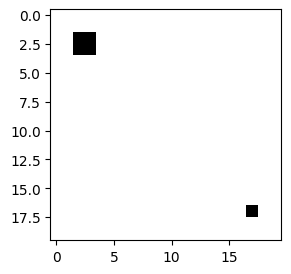

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.imshow(legal, cmap='Greys', interpolation='nearest')
# plt.tight_layout()
plt.show()

### Dual-encoding layers

#### PhoBERT General

In [6]:
class PhoBertEmbedding(nn.Module):
    def __init__(self, model_name="vinai/phobert-base", device=None, freeze=False, max_length = 256):
        super().__init__()
        
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        
        self.max_length = max_length
        
        if freeze:
            for p in self.model.parameters():
                p.requires_grad = False

    def encode(self, texts):
        toks = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length = self.max_length)
        input_ids = toks["input_ids"].to(self.device)
        attention_mask = toks["attention_mask"].to(self.device)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        # last_hidden_state: (batch, seq_len, hidden)
        return outputs.last_hidden_state, attention_mask, toks
    
    #only different by name but for Module usage
    def forward(self, texts):
        toks = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length = self.max_length)
        input_ids = toks["input_ids"].to(self.device)
        attention_mask = toks["attention_mask"].to(self.device)

        with torch.set_grad_enabled(not self.model.training):
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        return outputs.last_hidden_state, attention_mask, toks

In [7]:
text = 'Ban hành Nghị định sửa đổi Luật Đất đai'

phobert = PhoBertEmbedding(freeze=True)
embeddings, attention_mask, toks = phobert.encode([text])

#### Alternative if PhoBERT is not used

In [9]:
class SimpleTokenizer:
    def __init__(self):
        self.pad_token = "<pad>"
        self.cls_token = "<cls>"
        self.sep_token = "<sep>"
        self.unk_token = "<unk>"
        self.pad_token_id = 0
        self.cls_token_id = 1
        self.sep_token_id = 2
        self.unk_token_id = 3

    def tokenize(self, text):
        return text.split()

    def encode(self, text, max_length=256, padding=True, truncation=True, return_tensors=None):
        tokens = [self.cls_token] + text.split()[: max_length - 2] + [self.sep_token]
        input_ids = list(range(len(tokens)))  # dummy token ids
        attention_mask = [1] * len(input_ids)

        if padding and len(input_ids) < max_length:
            pad_len = max_length - len(input_ids)
            input_ids += [self.pad_token_id] * pad_len
            attention_mask += [0] * pad_len

        if return_tensors == "pt":
            import torch
            input_ids = torch.tensor([input_ids])
            attention_mask = torch.tensor([attention_mask])

        return {"input_ids": input_ids, "attention_mask": attention_mask}

    def __call__(self, text, **kwargs):
        return self.encode(text, **kwargs)

##### Toggle use of PhoBERT 


In [10]:
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"
os.environ["TRANSFORMERS_NO_JAX"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [12]:
use_phobert = True

if use_phobert:
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')
    print('PhoBERT enabled. Using PhoBERTEmbedder()')
else:
    tokenizer = SimpleTokenizer()
    phobert = None
    print("PhoBERT disabled. Using SimpleTokenizer().")

PhoBERT enabled. Using PhoBERTEmbedder()


#### Transformer Encoder

##### Positional Encoding

Modern Transformer-based models replace the traditional PE technique with using Relative Position. Instead of calculating the actual sinusoidal position of the token, the model encode the distance between Q-K tokens, which brings better information about how words interact with each other in a sentence. 

For a sequence of Length L: $$rel_{ij} = j - i$$

we get a matrix of shape (L,L) showing the relative distance of each token with one other

For T5-style Relative Position Bias, this embedding of relative distances gives a scalar bias per head per (i,j) and for each attention head h, we get a bias matrix $B^{(h)} \in R^{L x L}$

This bias is added directly to attention logits before the softmax:

$$Attention^{(h)} = softmax(\frac{QK^T}{\sqrt{d_k}} + B^{(h)})V$$

and also be combined with the Lexicon masking 

$$Attention^{(h)} = softmax(M_D * (\frac{QK^T}{\sqrt{d_k}} + B^{(h)}))V$$

##### POStag processing

For a batch of n sentence, which with l length [a,b,c,....] and a total of K possible POS tag, we create a relative POStag for each sentence: 

$$n_{[i,j]} = (pos_i, pos_j)$$

$$n_{[i, j]} = pos_i * K + pos_j$$

and We can get the embedding of this representation P = (batch_size, n_heads, l, l)

Add with Postag 

$$Attention_{Multihead Self}^{(h)} = softmax(\frac{QK^T}{\sqrt{d_k}} + B^{(h)} + M_L+ P)V$$

Where: 

* Q: Query matrix (current token) (l, l)

* K: Key matrix (each other token in the sentence) (l, l)

* V: Value matrix (value of each other token) (l, l)

* $d_k$: head_dim (= hidden dim/ n_head)

* $B^{(h)}$: Relative Positional Encoding (n_heads, l, l)

* $M_L$: Lexicon Mask (l, l)

* $P$: Relative POStag encoding (B, n_heads, l, l)

In [8]:
## Learned absolute positions

class RelativePositionBias(nn.Module):
    """
    biases that are added to attention logits.
    """
    def __init__(self, max_distance, n_heads):
        super().__init__()
        self.max_distance = max_distance
        self.n_heads = n_heads
        # relative distances range from -max_distance..+max_distance -> 2*max_distance+1 buckets for exmple -8->8 to 0->16
        self.rel_emb = nn.Embedding(2 * max_distance + 1, n_heads)

    def forward(self, seq_len, device=None):
        device = device or next(self.rel_emb.parameters()).device
        # compute matrix of relative distances j - i
        idxs = torch.arange(seq_len, device=device)
        rel = idxs.unsqueeze(0) - idxs.unsqueeze(1)  # (seq, seq) with relative distances
        clipped = rel.clamp(-self.max_distance, self.max_distance) + self.max_distance #clip the values to positive range
        biases = self.rel_emb(clipped).permute(2, 0, 1)  # (n_heads, seq, seq) embedding for trainable
        return biases 

In [10]:
## Traditional sinusoidal positions

import math

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, dim: int, max_len: int = 5000):
        super().__init__()
        self.dim = dim

        # a long enough matrix of position encodings
        position = torch.arange(max_len).unsqueeze(1) #(max_len, 1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))

        #sine/cosine positional encodings
        pe = torch.zeros(max_len, dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, dim)

        # Register as buffer (not a parameter, not updated by optimizer)
        self.register_buffer("pe", pe)

    def forward(self, seq_len: int, device=None):
        """
        Returns positional encodings for a sequence of length seq_len.
        Output shape: (1, seq_len, dim)
        """
        device = device or self.pe.device
        return self.pe[:, :seq_len].to(device)

In [14]:
#Postag processing

class POSTag(nn.Module):
    def __init__(self, n_postags, n_heads):
        super().__init__()
        self.n_postags = int(n_postags)   
        self.n_heads = n_heads
        self.bias_table = nn.Embedding(self.n_postags * self.n_postags, n_heads)

    def forward(self, postag_ids):
        postag_ids = postag_ids.long()

        B, L = postag_ids.shape
        device = postag_ids.device             
        self.bias_table = self.bias_table.to(device)
        tag_i = postag_ids.unsqueeze(2).expand(B, L, L)
        tag_j = postag_ids.unsqueeze(1).expand(B, L, L)

        pair_index = tag_i * self.n_postags + tag_j
        pair_index = pair_index.long()  

        bias = self.bias_table(pair_index)  # [B, L, L, n_heads]
        bias = bias.permute(0, 3, 1, 2).contiguous()
        return bias

##### Multi-head Self-Attention layer

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.1, pre_ln=True, use_rel_pos=True):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.d_k = dim // n_heads
        self.scale = self.d_k ** 0.5
        self.pre_ln = pre_ln
        self.use_rel_pos = use_rel_pos  

        self.W_q = nn.Linear(dim, dim)
        self.W_k = nn.Linear(dim, dim)
        self.W_v = nn.Linear(dim, dim)
        self.W_o = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        query,
        context=None,
        pos_bias=None,     # expected from RelativePositionBias
        sinusoidal_pe=None, # expected from SinusoidalPositionalEncoding
        postag_bias=None,
        mask=None,
        lex_mask=None,
        multiplicative=False,
    ):
        if context is None:
            context = query  # self-attention
        residual = query

        if self.pre_ln:
            query = self.norm(query)

        if not self.use_rel_pos and sinusoidal_pe is not None:
            seq_len = query.size(1)
            query = query + sinusoidal_pe[:, :seq_len, :].to(query.device)
            context = context + sinusoidal_pe[:, :seq_len, :].to(context.device)

        B, L, _ = query.size()
        _, S, _ = context.size()

        Q = self.W_q(query).view(B, L, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(context).view(B, S, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(context).view(B, S, self.n_heads, self.d_k).transpose(1, 2)

        attn_logits = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        if self.use_rel_pos and pos_bias is not None:
            attn_logits = attn_logits + pos_bias.unsqueeze(0)

        if postag_bias is not None:
            B2, H2, Lp, _ = postag_bias.shape
            _, H, L, S = attn_logits.shape
            if Lp != L:
                if Lp < L:
                    pad_len = L - Lp
                    postag_bias = F.pad(postag_bias, (0, pad_len, 0, pad_len), value=0.0)
                else:
                    postag_bias = postag_bias[:, :, :L, :L]
            attn_logits = attn_logits + postag_bias


        # Lexicon masking
        if lex_mask is not None:
            lex_mask = lex_mask.unsqueeze(1).unsqueeze(2)
            attn_logits = attn_logits * lex_mask if multiplicative else attn_logits + lex_mask


        # Attention masking
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            attn_logits = attn_logits.masked_fill(mask == 0, float('-inf'))

        attn = F.softmax(attn_logits, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, V).transpose(1, 2).contiguous().view(B, L, self.dim)
        out = self.W_o(out)
        out = self.dropout(out)
        
        #Residual Connection
        out = out + residual
        if not self.pre_ln:
            out = self.norm(out)

        return out, attn

##### Feed-Forward NN with Residual Connection and LayerNorm

Note that modern models (T5, DeBERTa, GPT) apply Pre-LN which is LayerNorm before running the first linear combination and also apply 2 dropout after each linear combination to help regularize the parameters to avoid overfitting, useful in large deep models

Also modern models utilize the GeLU activation instead of traditional ReLU in the MLP

GeLU: Gaussian Error Linear Unit has the mathematical definition: 

$$GeLU(x) = x.\Theta(x)$$

where $\Theta(x)$ is the cumulative distribution function (CDF) of a standard normal distribution 

$$GeLU(x) = 0.5x(1 + erf(\frac{x}{\sqrt{2}}))$$

Instead of making hard decision whether x > 0 in ReLU, GeLU makes a probabilistic decision based on how large x is, this makes the gradient smoother than ReLU and allows smoother transition while partially keeping small negative values

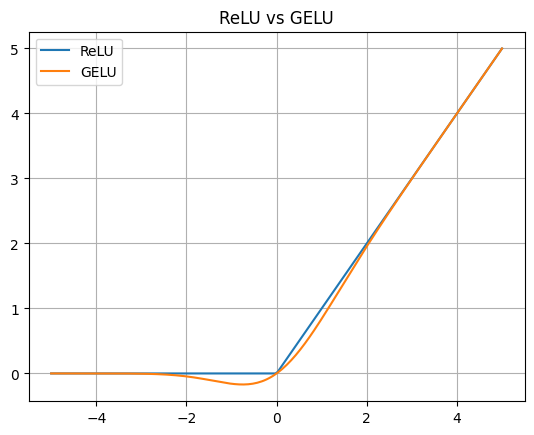

In [16]:
x = torch.linspace(-5, 5, 200)
relu = F.relu(x)
gelu = F.gelu(x)

plt.plot(x, relu, label='ReLU')
plt.plot(x, gelu, label='GELU')
plt.legend()
plt.grid(True)
plt.title("ReLU vs GELU")
plt.show()

In [12]:
class FeedForward(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()
        hidden_dim = hidden_dim or 4 * dim  # default expansion that hidden dim is 4 x model_dim
        self.norm = nn.LayerNorm(dim)
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Pre-LN + MLP + Residual
        residual = x
        x = self.norm(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return residual + x #Skip connection

#### Encoder Layer

In [13]:
class TransformerEncoder(nn.Module):
    def __init__(
        self,
        dim,
        n_heads,
        dropout=0.1,
        ff_hidden_dim=None,
        max_distance=256,
        pre_ln=True,
        num_postags=None,
        use_rel_pos=True,    
        max_seq_len=5000         
    ):
        super().__init__()
        self.use_rel_pos = use_rel_pos

        # Attention + Feedforward
        self.attn = MultiHeadAttention(
            dim,
            n_heads,
            dropout=dropout,
            pre_ln=pre_ln,
            use_rel_pos=use_rel_pos   # pass toggle
        )
        self.ff = FeedForward(dim, hidden_dim=ff_hidden_dim, dropout=dropout)

        # Positional representations
        if use_rel_pos:
            self.pos_module = RelativePositionBias(max_distance=max_distance, n_heads=n_heads)
        else:
            self.pos_module = SinusoidalPositionalEncoding(dim, max_len=max_seq_len)

        # Optional POS-tag bias
        self.postag_bias = POSTag(n_postags=num_postags, n_heads=n_heads) if num_postags is not None else None

    def forward(self, x, postag_ids=None, lex_mask=None):
        seq_len = x.size(1)
        device = x.device

        # Get positional representation depending on mode

        if self.use_rel_pos:
            pos_rep = self.pos_module(seq_len, device=device)  # (n_heads, L, L)
            pos_kwargs = {"pos_bias": pos_rep, "sinusoidal_pe": None}
        else:
            pos_rep = self.pos_module(seq_len, device=device)  # (1, L, dim)
            pos_kwargs = {"pos_bias": None, "sinusoidal_pe": pos_rep}


        # Compute POS-tag bias if applicable
        postag_bias = None
        if self.postag_bias is not None and postag_ids is not None:
            postag_bias = self.postag_bias(postag_ids)  # (B, n_heads, L, L)
            postag_bias = postag_bias[..., :seq_len, :seq_len]

        #  Self-Attention
        x, _ = self.attn(
            query=x,
            context=None,
            postag_bias=postag_bias,
            lex_mask=lex_mask,
            **pos_kwargs   # dynamically pass correct positional arg
        )

        #  Feed Forward

        x = self.ff(x)
        return x


In [16]:
class StackedEncoder(nn.Module):
    def __init__(self,
                 dim=768,
                 n_heads=12,
                 ff_hidden_dim=2048,
                 dropout=0.1,
                 max_distance=128,
                 pre_ln=True,
                 num_postags=None,
                 use_rel_pos = True,
                 num_layers=6):  # number of encoder blocks
        super().__init__()

        # Stack of independent TransformerEncoder blocks
        self.layers = nn.ModuleList([
            TransformerEncoder(
                dim=dim,
                n_heads=n_heads,
                dropout=dropout,
                ff_hidden_dim=ff_hidden_dim,
                max_distance=max_distance,
                pre_ln=pre_ln,
                num_postags=num_postags,
                use_rel_pos = use_rel_pos
            )
            for _ in range(num_layers)
        ])

        # Final normalization — important if using pre-LN blocks (like your TransformerEncoder)
        self.final_norm = nn.LayerNorm(dim) if pre_ln else nn.Identity()

    def forward(self, x, postag_ids=None, lex_mask=None, output_hidden_states=False):

        hidden_states = []

        for layer in self.layers:
            x = layer(x, postag_ids=postag_ids, lex_mask=lex_mask)
            if output_hidden_states:
                hidden_states.append(x)

        # Apply normalization after all layers (for pre-LN Transformer)
        x = self.final_norm(x)

        if output_hidden_states:
            return x, hidden_states
        return x

In [17]:
class CombinedEmbedding(nn.Module):
    def __init__(self, phobert=None, transformer_encoder=None, alpha=0.5, use_phobert=False, max_len=256):
        super().__init__()
        self.use_phobert = use_phobert
        self.phobert = phobert if use_phobert else None
        self.encoder = transformer_encoder
        self.alpha = nn.Parameter(torch.tensor(alpha))  # learnable interpolation factor
        self.max_len = max_len

    def forward(self, texts, input_ids=None):
        batch_size = len(texts)
        device = next(self.encoder.parameters()).device
        seq_len = self.max_len
        hidden_dim = self.encoder.input_dim if hasattr(self.encoder, "input_dim") else 768

        if self.use_phobert and self.phobert is not None:
            pho_hidden, attn_mask, toks = self.phobert.encode(texts)
            # truncate/pad pho_hidden if needed
            if pho_hidden.size(1) > seq_len:
                pho_hidden = pho_hidden[:, :seq_len, :]
                attn_mask = attn_mask[:, :seq_len]
            elif pho_hidden.size(1) < seq_len:
                pad_len = seq_len - pho_hidden.size(1)
                pho_hidden = torch.cat([pho_hidden, torch.zeros(batch_size, pad_len, hidden_dim, device=device)], dim=1)
                attn_mask = torch.cat([attn_mask, torch.zeros(batch_size, pad_len, device=device)], dim=1)
        else:
            pho_hidden = torch.zeros(batch_size, seq_len, hidden_dim, device=device)
            attn_mask = torch.ones(batch_size, seq_len, device=device)
            toks = None

        trans_hidden = self.encoder(pho_hidden, attn_mask)
        alpha = torch.clamp(self.alpha, 0.0, 1.0)

        if not self.use_phobert:
            return trans_hidden, attn_mask, toks

        combined = alpha * pho_hidden + (1 - alpha) * trans_hidden
        return combined, attn_mask, toks

In [19]:
if use_phobert == True:
    phobert = PhoBertEmbedding(freeze=True)

if use_phobert == False:
    phobert = None
    
encoder = StackedEncoder(dim=768, n_heads=12, ff_hidden_dim=2048, dropout=0.1, num_layers=6, max_distance = 128, use_rel_pos = False)

combined_model = CombinedEmbedding(None, encoder, alpha=0.5)

texts = [
    "Doanh nghiệp có thu nhập chịu thuế quy định tại Điều 3 của Luật này phải nộp thuế.",
    "Quyết định Căn cứ Nghị định số 55/2025/NĐ-CP ngày 02 tháng 3 năm 2025 của Chính phủ quy định chức năng, nhiệm vụ, quyền hạn và cơ cấu tổ chức của Bộ Khoa học và Công nghệ"
]

combined_output, attn_mask, toks = combined_model(texts)
print(combined_output.shape)  # (batch, seq_len, hidden_dim)

torch.Size([2, 256, 768])


### Decoder

#### Additional BiLSTM to catch the semantic structure

In [20]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim // 2,
                              num_layers=num_layers,
                              dropout=dropout,
                              bidirectional=True,
                              batch_first=True)
    def forward(self, x):
        output, _ = self.bilstm(x)
        return output

#### Decoder Head (for Triplet prediction)

In [ ]:
#Indenpendent Prediction

class DecoderHeads(nn.Module):
    def __init__(self, hidden_dim, num_relations):
        super().__init__()
        self.self_root = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.relation = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, num_relations)
        )

        # span for start and end indices
        self.start = nn.Linear(hidden_dim, 1)
        self.end = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # pool once for classification
        pooled = x.mean(dim=1)  #(batch_size, hidden_dim)

        self_root_logits = self.self_root(pooled).squeeze(-1)
        relation_logits = self.relation(pooled)

        # start and end idx
        start_logits = self.start(x).squeeze(-1)
        end_logits = self.end(x).squeeze(-1)

        return self_root_logits, relation_logits, start_logits, end_logits

In [ ]:
#Recursive prediction

class DecoderHeadCopy(nn.Module):
    def __init__(self, hidden_dim, num_relations):
        super().__init__()
        
        self.root = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.relation = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, num_relations)
        )

        self.start_head = nn.Sequential(
            nn.Linear(hidden_dim * 2 + num_relations, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )

        self.end_head = nn.Sequential(
            nn.Linear(hidden_dim * 3 + num_relations, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        """
        x: Tensor of shape (B, L, H)
        """
        if x.dim() == 4:
            x = x.squeeze(1)  # handle (B, 1, L, H)

        # root
        root_logits = self.root(x).squeeze(-1)  # (B, L)
        root_probs = torch.sigmoid(root_logits)
        root_vec = (x * root_probs.unsqueeze(-1)).sum(dim=1) / root_probs.sum(dim=1, keepdim=True).clamp(min=1.0)  # (B, H)

        # relation based on root
        root_context = root_vec.unsqueeze(1).expand(-1, x.size(1), -1)  # (B, L, H)
        rel_input = torch.cat([x, root_context], dim=-1)  # (B, L, 2H)
        rel_logits = self.relation(rel_input).mean(dim=1)  # (B, num_rel)
        rel_probs = F.softmax(rel_logits, dim=-1)

        # start idx based on root and relation
        rel_context = rel_probs.unsqueeze(1).expand(-1, x.size(1), -1)  # (B, L, num_rel)
        start_input = torch.cat([x, root_context, rel_context], dim=-1)
        start_logits = self.start_head(start_input).squeeze(-1)  # (B, L)
        start_probs = F.softmax(start_logits, dim=-1)
        start_vec = (x * start_probs.unsqueeze(-1)).sum(dim=1)  # (B, H)

        # end idx based on root, relation and start idx
        start_context = start_vec.unsqueeze(1).expand(-1, x.size(1), -1)
        end_input = torch.cat([x, root_context, rel_context, start_context], dim=-1)
        end_logits = self.end_head(end_input).squeeze(-1)  # (B, L)

        return root_logits, rel_logits, start_logits, end_logits

#### Decoder

In [23]:
class DecoderBody(nn.Module):
    def __init__(self,
                 hidden_dim=768,
                 num_heads=8,
                 ffn_dim=2048,
                 dropout=0.1,
                 pre_ln=True):
        super().__init__()
        self.cross_attn = MultiHeadAttention(hidden_dim, num_heads, dropout=dropout, pre_ln=pre_ln)
        self.bilstm = BiLSTMEncoder(hidden_dim, hidden_dim)
        self.ffn = FeedForward(hidden_dim, ffn_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, decoder_state, encoder_output, mask=None):
        # Project decoder_state to match encoder_output dim if needed
        if decoder_state.size(-1) != encoder_output.size(-1):
            project_to_dim = nn.Linear(decoder_state.size(-1), encoder_output.size([-1])).to(decoder_state.device)
            decoder_state = project_to_dim(decoder_state)

        # Ensure shape [B, L, D]
        if decoder_state.dim() == 2:
            decoder_state = decoder_state.unsqueeze(-1).repeat(1, 1, encoder_output.size(-1))

        # ---- Cross-Attention ----
        cross_out, _ = self.cross_attn(
            query=decoder_state,
            context=encoder_output,
            mask=mask
        )
        x = self.norm(cross_out + decoder_state)
        x = self.dropout(x)

        # ---- BiLSTM + FFN ----
        x = self.bilstm(x)
        x = self.ffn(x)

        return x  # [B, L, D]

In [25]:
class StackedDecoder(nn.Module):
    def __init__(self,
                 hidden_dim=768,
                 num_heads=8,
                 num_relations=10,
                 ffn_dim=2048,
                 dropout=0.1,
                 pre_ln=True,
                 num_layers=6,
                 recursive=False):
        super().__init__()

        # Stack of N DecoderBody blocks (no heads inside)
        self.layers = nn.ModuleList([
            DecoderBody(
                hidden_dim=hidden_dim,
                num_heads=num_heads,
                ffn_dim=ffn_dim,
                dropout=dropout,
                pre_ln=pre_ln
            )
            for _ in range(num_layers)
        ])

        # Final normalization after stacked layers
        self.final_norm = nn.LayerNorm(hidden_dim)

        # Shared decoder head
        self.head1 = DecoderHeads(hidden_dim, num_relations)
        self.head2 = DecoderHeadCopy(hidden_dim, num_relations)
        self.recursive = recursive

    def forward(self, decoder_state, encoder_output, mask=None):
        """
        decoder_state: [B, L, D] or [B, L]
        encoder_output: [B, L, D]
        mask: [B, L] optional
        """

        x = decoder_state

        # Sequentially pass through each DecoderBody block
        for layer in self.layers:
            x = layer(x, encoder_output, mask)

        # Final normalization
        x = self.final_norm(x)

        # Apply the shared decoder head
        if self.recursive:
            return self.head2(x)
            
        return self.head1(x)

### Full Transformer Architecture

In [26]:
class Transformer(nn.Module):
    def __init__(self,
                 phobert_embedder=None,
                 encoder=None,
                 decoder=None,
                 alpha=0.5,
                 use_phobert=False):
        super().__init__()

        self.use_phobert = use_phobert
        self.embedding = phobert_embedder  
        self.encoder = encoder              # StackedEncoder
        self.decoder = decoder              # StackedDecoder
        self.alpha = alpha

    def forward(self, texts, postag_ids):

        combined_output, attn_mask, toks = self.embedding(texts)
        # combined_output: (B, L, D)
        # attn_mask:      (B, L)

        #multi-block encoder
        encoded_output = self.encoder(
            combined_output,
            postag_ids=postag_ids,
            lex_mask=attn_mask
        )

        decoder_output = self.decoder(
            decoder_state=encoded_output,
            encoder_output=encoded_output,
            mask=attn_mask
        )

        # if StackedDecoder returns logits directly (root, rel, start, end), unpack them here:
        if isinstance(decoder_output, tuple) and len(decoder_output) == 4:
            root_logits, relation_logits, start_logits, end_logits = decoder_output
        else:
            # if stacked decoder only returns the last hidden state
            root_logits = relation_logits = start_logits = end_logits = None

        return {
            "self_root": root_logits,
            "relation": relation_logits,
            "start_logits": start_logits,
            "end_logits": end_logits,
            "mask": attn_mask,
            "tokens": toks
        }

#### Model Definition and testing

In [27]:
# df = pd.read_csv('D:/Study/Education/Projects/Group_Project/rag_model/model/RE/RE_training_final.csv')

df = pd.read_csv('/kaggle/input/traindataset/RE_training_final.csv')

In [30]:
# #Process Postagging

# import ast
# df['postag'] = df['postag'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# unique_tags = sorted({tag for tags in df['postag'] for tag in tags})

# pos2idx = {tag: idx for idx, tag in enumerate(unique_tags, start=1)}  # start=1 to reserve 0 for padding
# idx2pos = {idx: tag for tag, idx in pos2idx.items()}

# df['postag_idx'] = df['postag'].apply(lambda tags: [pos2idx[tag] for tag in tags])

# print(pos2idx)

In [28]:
relations = sorted(df["relation"].unique())
relation2id = {rel: idx for idx, rel in enumerate(relations)}
id2relation = {v: k for k, v in relation2id.items()}

print(relation2id)

{'Amended': 0, 'Drop': 1, 'Guide': 2, 'Others': 3, 'PartDrop': 4, 'PartReplace': 5, 'Pursuant': 6, 'Reference': 7, 'Replace': 8}


In [29]:
### Test with Postag
#Require definitions of df first with the existence of postag_ids

from torch.nn.utils.rnn import pad_sequence

device = 'cuda' #when run on local

texts = df['input_text'].iloc[:2].tolist()
# postags = df['postag'].iloc[:2].tolist()
# pos_ids = [torch.tensor(p, dtype=torch.long) for p in df['postag_idx'].iloc[:2]]

# pos_ids = pad_sequence(pos_ids, batch_first=True, padding_value=0).long().to(device)

if use_phobert:
    phobert = PhoBertEmbedding(freeze=True, max_length=256)
    phobert.to(device)
    print('PhoBERT enabled. Using PhoBERT')
else:
    phobert = None
    print("PhoBERT disabled. Using encoder-only embeddings.")

# initialize encoder & decoder 
encoder = StackedEncoder(
    dim=768,
    n_heads=8,
    ff_hidden_dim=2048,
    dropout=0.1,
    # num_postags=len(pos2idx),
    num_layers=1,
    use_rel_pos = False
).to(device)

decoder = StackedDecoder(
    hidden_dim=768,
    num_heads=8,
    num_relations=10,
    num_layers=3,
    recursive=False
).to(device)


embedding = CombinedEmbedding(
    phobert=phobert,
    transformer_encoder=encoder,
    alpha=0.5,
    use_phobert=use_phobert
)

model = Transformer(
    phobert_embedder=embedding,
    encoder=encoder,
    decoder=decoder,
    alpha=0.5,
    use_phobert=use_phobert
).to(device)

outputs = model(texts, postag_ids=None)

print(outputs["self_root"].shape)    # torch.Size([B])
print(outputs["relation"].shape)     # torch.Size([B, num_relations])
print(outputs["start_logits"].shape) # torch.Size([B, seq_len])
print(outputs["end_logits"].shape)   # torch.Size([B, seq_len])

PhoBERT enabled. Using PhoBERT


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


torch.Size([2])
torch.Size([2, 10])
torch.Size([2, 256])
torch.Size([2, 256])


#### Model Summary

In [30]:
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total/1e6:.1f}M, Trainable: {trainable/1e6:.1f}M")

Total params: 172.7M, Trainable: 37.7M


### Data Loading 

#### Preprocessing

In [34]:
# df = gs_to_df_pandas('RE_training')

# df['input_text'] = df['input_text'].apply(lambda x: x.replace('_', ' '))

# df['second_entity'] = df['second_entity'].apply(lambda x: x.replace('_', ' '))

In [35]:
# df.head()

In [36]:
# def get_word_indices(row):
#     # Clean punctuation and normalize spaces
#     text = re.sub(r'[^\w\s]', '', row['input_text'])
#     entity = re.sub(r'[^\w\s]', '', row['second_entity'])
    
#     text_words = text.split()
#     entity_words = entity.split()
    
#     n = len(entity_words)
    
#     # Find first matching subsequence
#     for i in range(len(text_words) - n + 1):
#         if text_words[i:i+n] == entity_words:
#             return pd.Series({'start_word_idx': i, 'end_word_idx': i + n - 1})
    
#     # Not found
#     return pd.Series({'start_word_idx': -1, 'end_word_idx': -1})

In [37]:
# df[["start_idx", "end_idx"]] = df.apply(get_word_indices, axis=1).astype(int)

# df['first_entity'] = df['first_entity'].apply(lambda x: 1 if x == 'self' else 0)

# df = df.rename(columns={'first_entity': 'self_root'})

In [38]:
# df

In [39]:
# write_df_to_gs(df, 'RE_training_final')

#### Final 

#### Add extra input feature from text - postagging

In [40]:
# postag = df['input_text'].apply(lambda x: annotator.annotate(x))

In [41]:
# def create_pos(text):   
#     pos_tagging = []

#     pos = annotator.annotate(text)

#     for result_item in pos:

#         sentence_segments = result_item['sentences'][0]
        
#         current_sentence_tags = []
#         for segment in sentence_segments:
#             word_form = segment['form']
#             pos_tag = segment['posTag']
            
#             sub_words = word_form.split('_')
#             repeated_tags = [pos_tag] * len(sub_words)
#             current_sentence_tags.extend(repeated_tags)
#         pos_tagging.append(current_sentence_tags)

In [42]:
# print('Original text:')
# print(df['input_text'][0])
# print('Postag:')
# print(pos_tagging[0])

In [43]:
# df['postag'] = pos_tagging

# df

#### Create dataset and Labeling

In [31]:
from torch.utils.data import Dataset

class trainDataset(Dataset):
    def __init__(self, df, tokenizer, relation2id, max_length=256):
        self.df = df
        self.tokenizer = tokenizer
        self.relation2id = relation2id
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["input_text"]

        # Tokenize text
        encoded = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=self.max_length
        )

        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)
        seq_len = int(attention_mask.sum())

        # # POS tagging indices
        # postag_idx = row["postag_idx"]
        # if not isinstance(postag_idx, list):
        #     postag_idx = [0]  # fallback if something went wrong

        # postag_tensor = torch.tensor(postag_idx, dtype=torch.long)
        # pad/truncate POS tag sequence to match tokenizer length
        # if len(postag_tensor) < self.max_length:
        #     pad_len = self.max_length - len(postag_tensor)
        #     postag_tensor = torch.cat([postag_tensor, torch.zeros(pad_len, dtype=torch.long)])
        # else:
        #     postag_tensor = postag_tensor[:self.max_length]

        # Start/End indices sanity check 
        start_idx = int(row["start_idx"])
        end_idx = int(row["end_idx"])
        if start_idx < 0 or end_idx < 0 or start_idx >= seq_len or end_idx >= seq_len:
            print(f"[WARN] invalid span indices at row {idx}: ({start_idx}, {end_idx}) | seq_len={seq_len}")
            start_idx, end_idx = 0, 0  # fallback inside range

        labels = {
            "self_root": torch.tensor(row["self_root"], dtype=torch.float),
            "relation": torch.tensor(self.relation2id[row["relation"]], dtype=torch.long),
            "start": torch.tensor(start_idx, dtype=torch.long),
            "end": torch.tensor(end_idx, dtype=torch.long)
        }

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            # "postag_ids": postag_tensor,
            "text": text,
            "labels": labels
        }

In [32]:
#Drop rows with no traced second entity and invalid entity span (outside of max_length)

bad_rows = df[(df["start_idx"] < 0) | (df["end_idx"] < 0)]
print("Invalid spans:", len(bad_rows))

df = df.drop(bad_rows.index).reset_index(drop=True)
df = df[(df["end_idx"] < 256)] #current max length
print("✅ Remaining rows after drop:", len(df))

Invalid spans: 0
✅ Remaining rows after drop: 32380


In [33]:
dataset = trainDataset(df, tokenizer, relation2id)

sample = dataset[0]
print(sample["text"])
print(sample["labels"])

Căn cứ Hiến pháp nước Cộng hòa xã hội chủ nghĩa Việt Nam;
{'self_root': tensor(1.), 'relation': tensor(6), 'start': tensor(2), 'end': tensor(12)}


In [34]:
from torch.utils.data import random_split, DataLoader

total_size = len(dataset)
test_size = int(0.2 * total_size)
train_size = total_size - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [35]:
num_batches = len(train_loader)
print(f"Number of train batches: {num_batches}")

num_batches2 = len(test_loader)
print(f"Number of test batches: {num_batches2}")

Number of train batches: 3238
Number of test batches: 810


#### Optim

In [ ]:
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.AdamW(model.parameters(), lr=2e-5)

criterion_root = torch.nn.BCEWithLogitsLoss()       # for root
criterion_relation = torch.nn.CrossEntropyLoss()    # for relation
criterion_span = torch.nn.CrossEntropyLoss()        # for start/end positions

num_epochs = 15

device = next(model.parameters()).device  # ensures correct device

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        texts = batch["text"]

        # Safe conversion for postag_ids
        # postag_ids = batch["postag_ids"].to(model.device if hasattr(model, "device") else "cuda")

        outputs = model(texts, postag_ids=None)

        # Unpack model outputs
        self_root_logits = outputs["self_root"]
        relation_logits = outputs["relation"]
        start_logits = outputs["start_logits"]
        end_logits = outputs["end_logits"]

        labels = batch["labels"]
        self_root_labels = labels["self_root"].to(self_root_logits.device)
        relation_labels = labels["relation"].to(relation_logits.device)
        start_labels = labels["start"].to(start_logits.device)
        end_labels = labels["end"].to(end_logits.device)

        # Compute loss
        loss_self_root = criterion_root(self_root_logits.squeeze(), self_root_labels)
        loss_relation = criterion_relation(relation_logits, relation_labels)
        loss_start = criterion_span(start_logits, start_labels)
        loss_end = criterion_span(end_logits, end_labels)

        total_batch_loss = loss_self_root + loss_relation + 0.5 * (loss_start + loss_end)

        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()

        total_loss += total_batch_loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")
    torch.save(model.state_dict(), 'state_dict.pth')

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
root_preds, root_labels = [], []
rel_preds, rel_labels = [], []
pred_spans, true_spans = [], []

with torch.no_grad():
    for batch in test_loader:   
        texts = batch["text"]
        outputs = model(texts, postag_ids = None)

        # self_root
        self_root_logits = outputs["self_root"].squeeze()
        self_root_labels = batch["labels"]["self_root"].to(self_root_logits.device)
        preds_root = (torch.sigmoid(self_root_logits) > 0.5).long()

        root_preds.extend(preds_root.cpu().numpy())
        root_labels.extend(self_root_labels.cpu().numpy())

        # relation
        relation_logits = outputs["relation"]
        relation_labels = batch["labels"]["relation"].to(relation_logits.device)
        preds_relation = torch.argmax(relation_logits, dim=1)

        rel_preds.extend(preds_relation.cpu().numpy())
        rel_labels.extend(relation_labels.cpu().numpy())

        # span
        start_logits = outputs["start_logits"]
        end_logits = outputs["end_logits"]
        start_labels = batch["labels"]["start"].to(start_logits.device)
        end_labels = batch["labels"]["end"].to(end_logits.device)

        pred_start = torch.argmax(start_logits, dim=1)
        pred_end = torch.argmax(end_logits, dim=1)

        for s_pred, e_pred, s_true, e_true in zip(pred_start, pred_end, start_labels, end_labels):
            pred_spans.append((s_pred.item(), e_pred.item()))
            true_spans.append((s_true.item(), e_true.item()))


root_precision = precision_score(root_labels, root_preds)
root_recall = recall_score(root_labels, root_preds)
root_f1 = f1_score(root_labels, root_preds)
root_acc = accuracy_score(root_labels, root_preds)

rel_acc = accuracy_score(rel_labels, rel_preds)
rel_f1 = f1_score(rel_labels, rel_preds, average='macro')

correct_spans = sum([1 for p, t in zip(pred_spans, true_spans) if p == t])
span_precision = correct_spans / len(pred_spans)
span_recall = correct_spans / len(true_spans)
span_f1 = 2 * span_precision * span_recall / (span_precision + span_recall + 1e-8)


print(f"self_root:   Accuracy: {root_acc:.4f} | Precision: {root_precision:.4f} | Recall: {root_recall:.4f} | F1: {root_f1:.4f}")
print(f"relation:    Accuracy: {rel_acc:.4f} | Macro-F1: {rel_f1:.4f}")
print(f"span         Precision: {span_precision:.4f} | Recall: {span_recall:.4f} | F1: {span_f1:.4f}")

self_root:   Accuracy: 0.9969 | Precision: 0.9847 | Recall: 0.9973 | F1: 0.9909
relation:    Accuracy: 0.9617 | Macro-F1: 0.8249
span         Precision: 0.8379 | Recall: 0.8379 | F1: 0.8379
